In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


#maintain consistent performance
tf.random.set_seed(42)
np.random.seed(42)

#confirm GPU is available
print("num GPUs:", len(tf.config.list_physical_devices('GPU')))

num GPUs: 1


In [5]:
dset = pd.read_csv('CData/emnist-balanced-train.csv', header=None)
dset.head()

0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0   45    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1   36    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2   43    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3   15    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4    4    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 785 columns]

In [6]:
dset.describe()

0         1         2         3         4              5    \
count  112800.00000  112800.0  112800.0  112800.0  112800.0  112800.000000   
mean       23.00000       0.0       0.0       0.0       0.0       0.001365   
std        13.56472       0.0       0.0       0.0       0.0       0.235046   
min         0.00000       0.0       0.0       0.0       0.0       0.000000   
25%        11.00000       0.0       0.0       0.0       0.0       0.000000   
50%        23.00000       0.0       0.0       0.0       0.0       0.000000   
75%        35.00000       0.0       0.0       0.0       0.0       0.000000   
max        46.00000       0.0       0.0       0.0       0.0      63.000000   

                 6              7              8              9    ...  \
count  112800.000000  112800.000000  112800.000000  112800.000000  ...   
mean        0.011560       0.020700       0.017438       0.018475  ...   
std         1.221826       1.658797       1.602478       1.719549  ...   
min         0.000000       0.000000       0.000000       0.000000  ...   
25%         0.000000       0.000000       0.000000       0.000000  ...   
50%         0.000000       0.000000       0.000000       0.000000  ...   
75%         0.000000       0.000000       0.000000       0.000000  ...   
max       192.000000     217.000000     217.000000     217.000000  ...   

                 775       776       777            778            779  \
count  112800.000000  112800.0  112800.0  112800.000000  112800.000000   
mean        0.000310       0.0       0.0       0.002163       0.000284   
std         0.104211       0.0       0.0       0.726499       0.095279   
min         0.000000       0.0       0.0       0.000000       0.000000   
25%         0.000000       0.0       0.0       0.000000       0.000000   
50%         0.000000       0.0       0.0       0.000000       0.000000   
75%         0.000000       0.0       0.0       0.000000       0.000000   
max        35.000000       0.0       0.0     244.000000      32.000000   

            780       781       782       783       784  
count  112800.0  112800.0  112800.0  112800.0  112800.0  
mean        0.0       0.0       0.0       0.0       0.0  
std         0.0       0.0       0.0       0.0       0.0  
min         0.0       0.0       0.0       0.0       0.0  
25%         0.0       0.0       0.0       0.0       0.0  
50%         0.0       0.0       0.0       0.0       0.0  
75%         0.0       0.0       0.0       0.0       0.0  
max         0.0       0.0       0.0       0.0       0.0  

[8 rows x 785 columns]

112800 rows (images), each described using 784 variables 28x28 pixels plus one column as output variable (first col).

In [7]:
dset.shape

(112800, 785)

In [8]:
# split dataset
dset = dset.loc[:,1:]
dset.shape

(112800, 784)

<function matplotlib.pyplot.show(*args, **kw)>

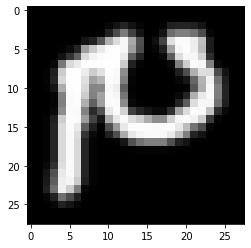

In [9]:
# normalize data
dset = np.expand_dims(dset,-1).astype('float32')/255
# reshape images to 28 x 28
dset = np.reshape(dset,(-1,28,28))
# get sample image to see what they look like
sample = dset[102]
plt.imshow(sample, cmap=plt.cm.gray)
plt.show

Image is rotated. To fix this, we have to flip it horizontally and rotate it 90 degrees anti-clockwise.
(https://stackoverflow.com/questions/48532761/letters-in-emnist-training-dataset-are-rotated-and-little-vague)

In [10]:
def rotate(sample):
  sample = np.fliplr(sample)
  sample = np.rot90(sample)
  return sample


<function matplotlib.pyplot.show(*args, **kw)>

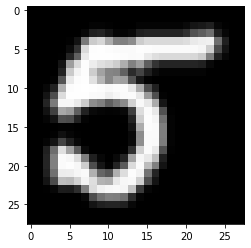

In [11]:
# Check if the rotate function worked
s1 = rotate(sample)
plt.imshow(s1, cmap=plt.cm.gray)
plt.show

In [12]:
dset = [rotate(x) for x in dset]

<function matplotlib.pyplot.show(*args, **kw)>

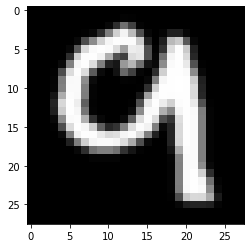

In [13]:
import random
# check if function worked for the whole dataset by looking at random element
r = random.randint(100, 1000)
s2 = dset[r]
plt.imshow(s2, cmap=plt.cm.gray)
plt.show

Dataset might be too big for GAN (more than 100,000 images), the ideal range according to NVIDIA is from 50,000 to 100,000.

In [14]:
dset = dset[:60000] 

Reshape data to dimensions needed by CNN layers, shuffle, and batch it.

In [15]:
BATCH_SIZE = 64
# convolution layers work 3 channels 
dset = np.reshape(dset,(-1,28,28,1))
# tensorflow dataset obj
dset =  tf.data.Dataset.from_tensor_slices(dset)
# set batch size for it not to read one image at a time
dset = dset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

Set up model for generator. Three COnv2DTranspose layers are used to construct the images.

In [16]:
# Generator's input is a noise vector hyperparameter (fine-tune later)
NOISE_DIM = 150
#used to be 150
# design generator model with unsampling layers
generator = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(NOISE_DIM,)),
    layers.Dense(7*7*256),
    layers.Reshape(target_shape=(7,7,256)),
    # Three COnv2DTranspose layers are used to construct the images. Similar to VAE.
    layers.Conv2DTranspose(256,3,activation="LeakyReLU",strides=2,padding="same"),
    layers.Conv2DTranspose(128,3,activation="LeakyReLU",strides=2,padding="same"),
    layers.Conv2DTranspose(1,3,activation="sigmoid",padding="same")
])

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1894144   
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 256)      590080    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      295040    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        1153      
 ranspose)                                                       
                                                        

Use untrained generator to create an image

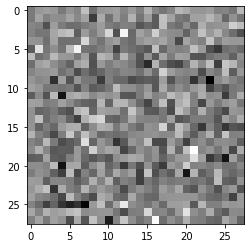

In [17]:
noise = tf.random.normal([1,NOISE_DIM])
new_image = generator(noise, training=False)
plt.imshow(new_image[0,:,:,0], cmap=plt.cm.gray)

Create discriminator model. Two Conv2D layers to downsample before going into a 64-neuron dense layer and a dropout to avoid overfitting. The output is binary, as the job is to classify the character images as real or fake until it cannot tell the difference anymore.

In [18]:
# create discriminator
discriminator = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(28,28,1)),
    # activation parameters were chosen on the basis that they are standard practice in GANs.
    layers.Conv2D(256,3,activation="relu", strides=2,padding="same"),
    layers.Conv2D(128,3,activation="relu", strides=2,padding="same"),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1,activation="sigmoid")
])

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 256)       2560      
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         295040    
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 64)                401472    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 699,137
Trainable params: 699,137
Non-tr

Set up optimizers, loss functions, and accuracy metrics. Hyperparameters to get the learning rates well in the generator and discriminator for the sake of stability.

In [19]:
# optimizers
G_optimizer = keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.5)
D_optimizer = keras.optimizers.Adam(learning_rate=0.00003, beta_1=0.5)

# loss function
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)

# accuracy metric
gAccMetric = tf.keras.metrics.BinaryAccuracy()
dAccMetric = tf.keras.metrics.BinaryAccuracy()

Define training function for one step of generator and one of the discriminator

In [20]:
@tf.function
def trainStep(x):
    # batch (32,28,28,1). Extract 32 value
    batch = tf.shape(x)[0]
    noise = tf.random.normal([batch,NOISE_DIM])
    # concatenate labels
    trD = tf.concat([
        # real labeled with 1
        tf.ones(batch, 1),
        # fake labeled with 0
        tf.zeros(batch,1)
    ], axis=0)
    trG = tf.ones(batch)
    
    with tf.GradientTape() as gTape, tf.GradientTape() as dTape:
        # test the outcome of generator
        gen = generator(noise)
        fakeO = discriminator(gen)
        realO = discriminator(x)

        # make discriminator detect the difference between real and fake data
        pred = discriminator(tf.concat([x,gen],axis=0))

        # calculate loss
        genLoss = loss_fn(trG,fakeO)
        disLoss = loss_fn(trD,pred)
    # apply backpropagation and update weights
    grG = gTape.gradient(genLoss, generator.trainable_weights)
    grD = dTape.gradient(disLoss,discriminator.trainable_variables)
    G_optimizer.apply_gradients(zip(grG,generator.trainable_weights))
    D_optimizer.apply_gradients(zip(grD,discriminator.trainable_variables))
    # accuracy
    gAccMetric.update_state(trG,fakeO)
    dAccMetric.update_state(trD,pred)
    

    # return loss for visualization
    return {
        # loss
        "gen loss": genLoss,
        "dis loss": disLoss,
        # accuracy
        "gen acc": gAccMetric.result(),
        "dis acc": dAccMetric.result()
    }

Visualize generated images

In [22]:
def plotPics(model):
    pics = model(np.random.normal(size=(81,NOISE_DIM)))
    plt.figure(figsize=(9,9))
    for i,pic in enumerate(pics):
        plt.subplot(9,9,i+1)
        plt.imshow(np.squeeze(pic,-1), cmap=plt.cm.gray)
        plt.axis('off')
    plt.show();

Define training loop

In [21]:
def train(set,e):
  # accumulate loss to calculate average and the end of each epoch
    dLossTotal = 0
    gLossTotal = 0
    dAccTotal = 0
    gAccTotal = 0
    count = 0
    for epoch in range(e):
      # loop dset one batch at a time
      for i in set:
        s = trainStep(i)
        dLossTotal += s['dis loss']
        gLossTotal += s['gen loss']
        gAccTotal += s['gen acc']
        dAccTotal += s['dis acc']
        # update count
        count += 1
      # record performance
      print("E:{},Loss G:{:0.4f},Loss D:{:0.4f},Acc G:%{:0.2f}, Acc D:%{:0.2f}".format(
        epoch,
        gLossTotal/count,
        dLossTotal/count,
        100 * (gAccTotal/count),
        100 * (dAccTotal/count)
    ))
      # generate images
      if epoch % 2 == 0:
          plotPics(generator)

E:0,Loss G:0.6819,Loss D:0.5163,Acc G:%0.00, Acc D:%91.66


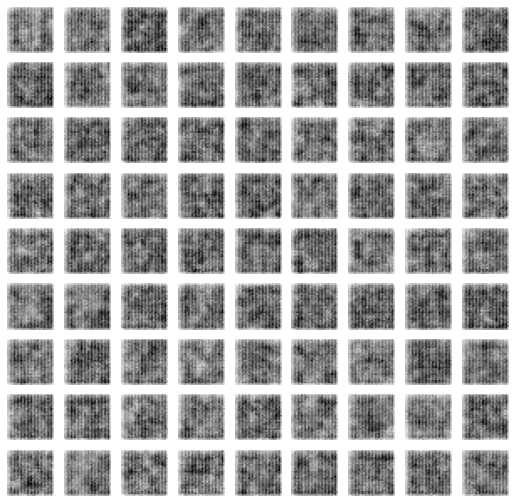

E:1,Loss G:0.6875,Loss D:0.5098,Acc G:%0.00, Acc D:%95.13
E:2,Loss G:0.6894,Loss D:0.5076,Acc G:%0.00, Acc D:%96.49


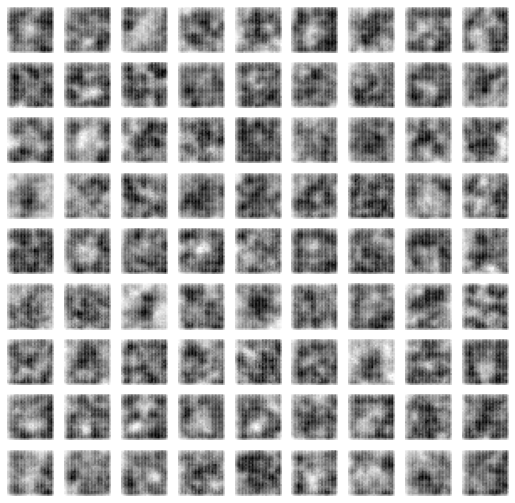

E:3,Loss G:0.6856,Loss D:0.5145,Acc G:%0.04, Acc D:%97.14
E:4,Loss G:0.6777,Loss D:0.5427,Acc G:%0.35, Acc D:%96.59


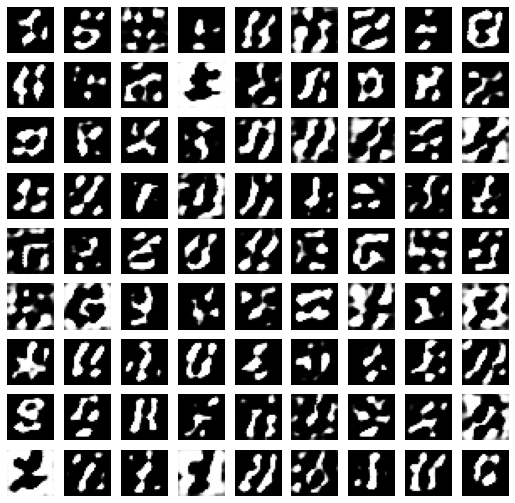

E:5,Loss G:0.6722,Loss D:0.5577,Acc G:%0.70, Acc D:%95.19
E:6,Loss G:0.6651,Loss D:0.5634,Acc G:%1.01, Acc D:%94.07


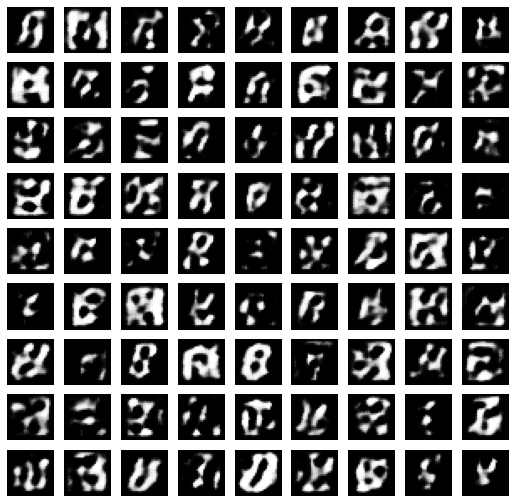

E:7,Loss G:0.6600,Loss D:0.5678,Acc G:%1.28, Acc D:%93.17
E:8,Loss G:0.6575,Loss D:0.5691,Acc G:%1.48, Acc D:%92.47


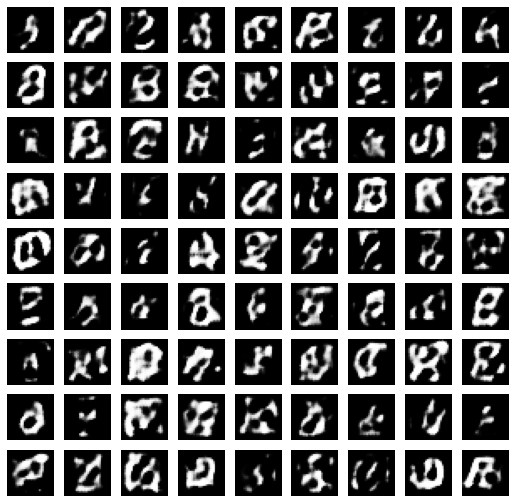

E:9,Loss G:0.6560,Loss D:0.5693,Acc G:%1.63, Acc D:%91.95
E:10,Loss G:0.6550,Loss D:0.5694,Acc G:%1.74, Acc D:%91.56


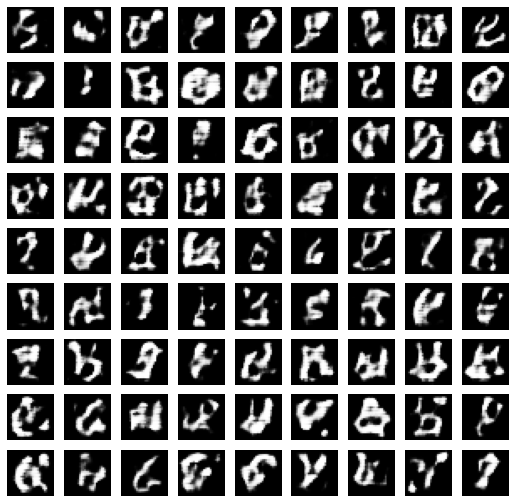

E:11,Loss G:0.6544,Loss D:0.5693,Acc G:%1.83, Acc D:%91.25
E:12,Loss G:0.6540,Loss D:0.5690,Acc G:%1.90, Acc D:%91.00


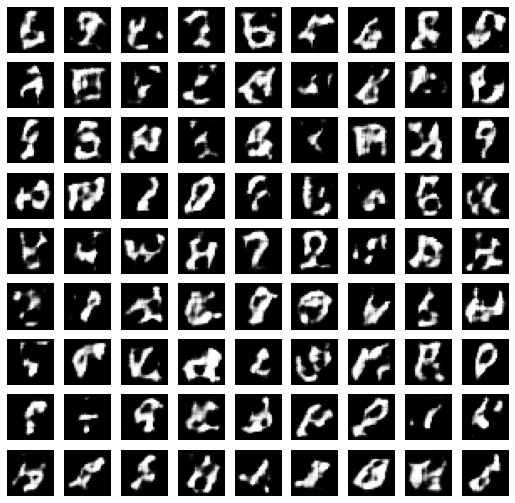

E:13,Loss G:0.6537,Loss D:0.5686,Acc G:%1.96, Acc D:%90.81
E:14,Loss G:0.6535,Loss D:0.5683,Acc G:%2.02, Acc D:%90.65


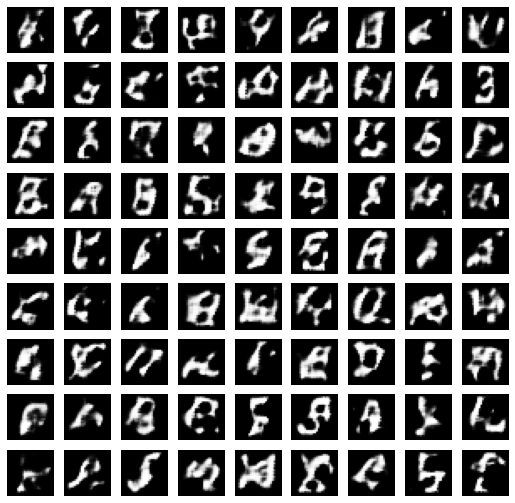

E:15,Loss G:0.6533,Loss D:0.5681,Acc G:%2.06, Acc D:%90.52
E:16,Loss G:0.6530,Loss D:0.5681,Acc G:%2.10, Acc D:%90.41


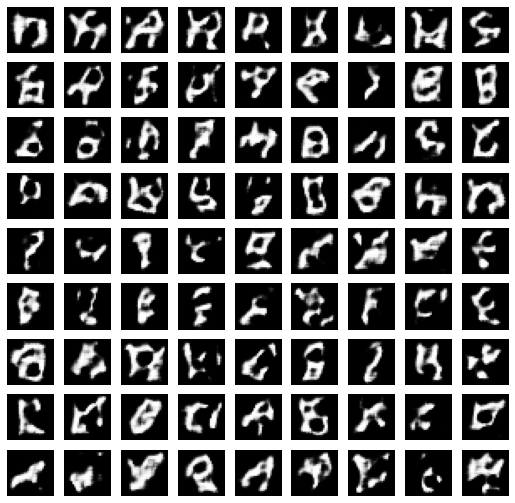

E:17,Loss G:0.6526,Loss D:0.5684,Acc G:%2.14, Acc D:%90.31
E:18,Loss G:0.6522,Loss D:0.5689,Acc G:%2.18, Acc D:%90.22


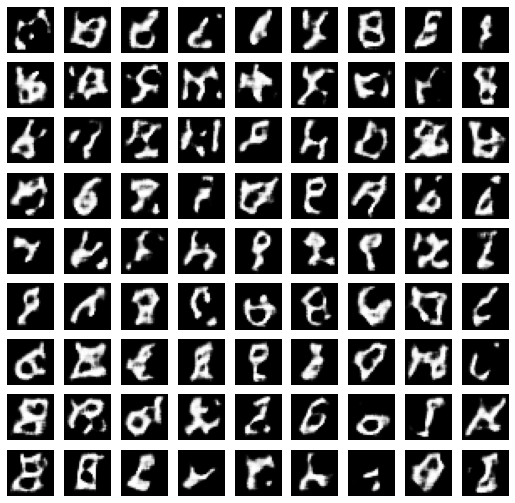

E:19,Loss G:0.6516,Loss D:0.5696,Acc G:%2.21, Acc D:%90.13
E:20,Loss G:0.6511,Loss D:0.5705,Acc G:%2.25, Acc D:%90.03


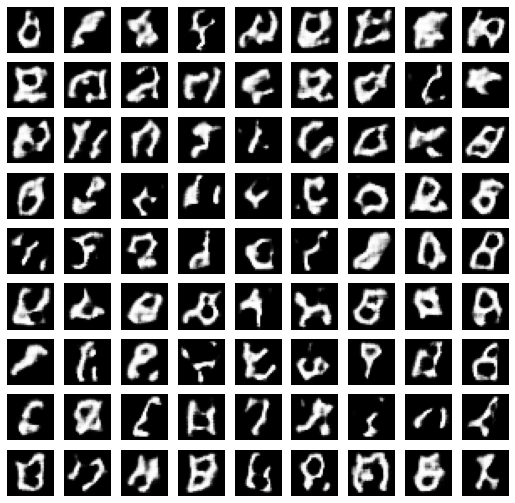

E:21,Loss G:0.6505,Loss D:0.5715,Acc G:%2.29, Acc D:%89.94
E:22,Loss G:0.6499,Loss D:0.5724,Acc G:%2.34, Acc D:%89.84


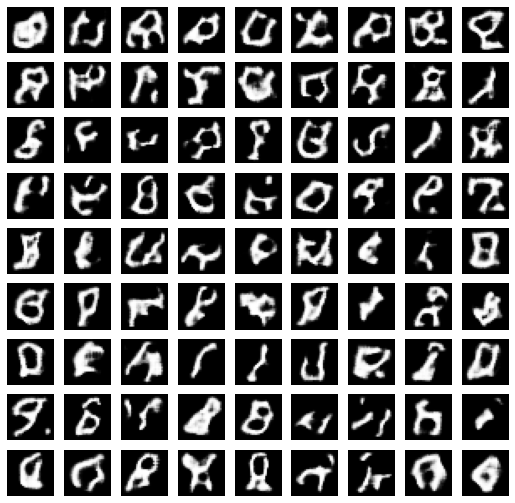

E:23,Loss G:0.6494,Loss D:0.5733,Acc G:%2.38, Acc D:%89.74
E:24,Loss G:0.6489,Loss D:0.5742,Acc G:%2.43, Acc D:%89.64


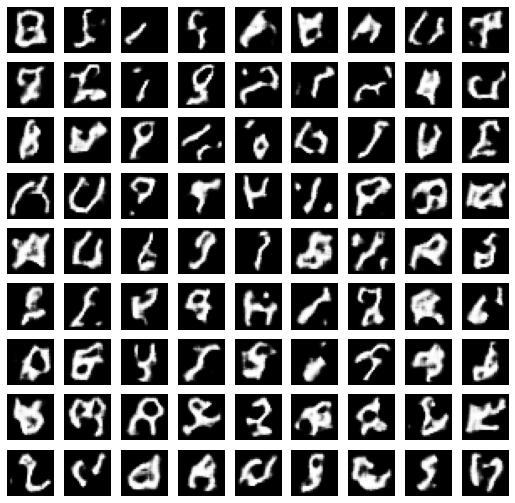

E:25,Loss G:0.6483,Loss D:0.5750,Acc G:%2.47, Acc D:%89.54
E:26,Loss G:0.6479,Loss D:0.5758,Acc G:%2.52, Acc D:%89.44


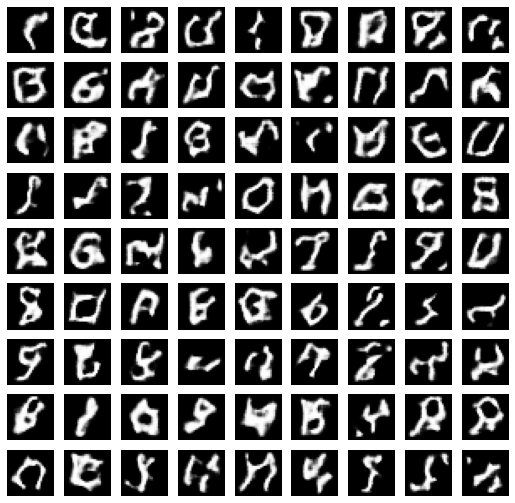

E:27,Loss G:0.6474,Loss D:0.5765,Acc G:%2.56, Acc D:%89.34
E:28,Loss G:0.6470,Loss D:0.5772,Acc G:%2.61, Acc D:%89.23


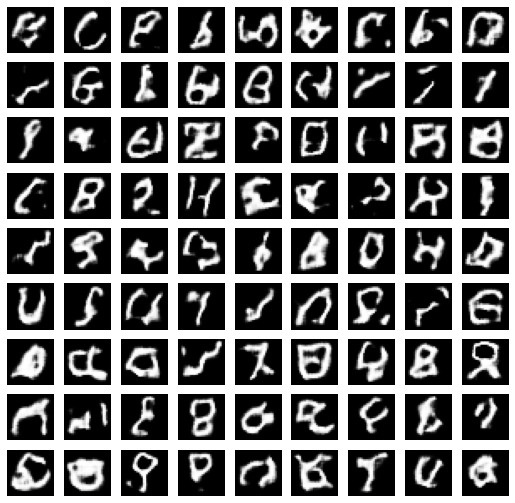

E:29,Loss G:0.6466,Loss D:0.5779,Acc G:%2.66, Acc D:%89.13
E:30,Loss G:0.6462,Loss D:0.5785,Acc G:%2.70, Acc D:%89.04


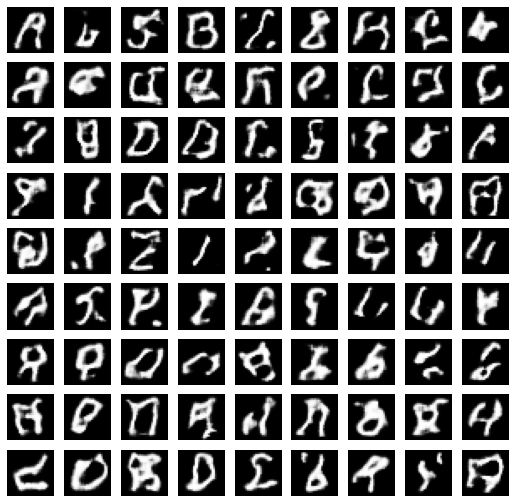

E:31,Loss G:0.6459,Loss D:0.5790,Acc G:%2.75, Acc D:%88.94
E:32,Loss G:0.6456,Loss D:0.5795,Acc G:%2.80, Acc D:%88.84


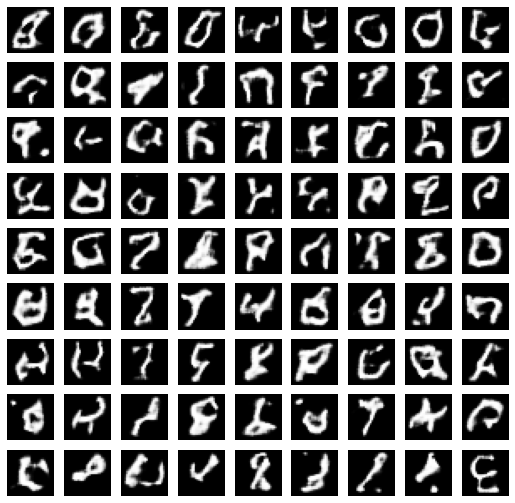

E:33,Loss G:0.6453,Loss D:0.5800,Acc G:%2.84, Acc D:%88.75
E:34,Loss G:0.6451,Loss D:0.5804,Acc G:%2.89, Acc D:%88.66


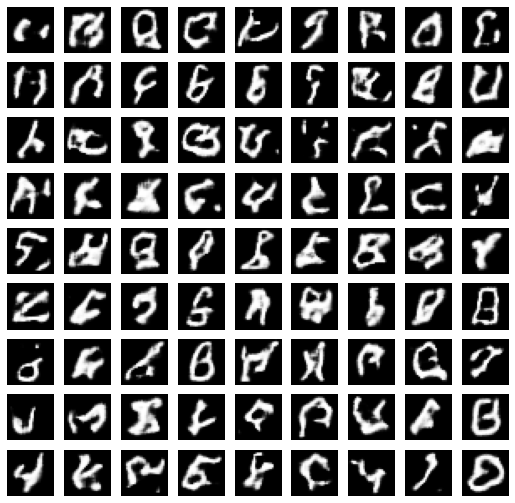

E:35,Loss G:0.6448,Loss D:0.5808,Acc G:%2.93, Acc D:%88.56
E:36,Loss G:0.6446,Loss D:0.5812,Acc G:%2.98, Acc D:%88.48


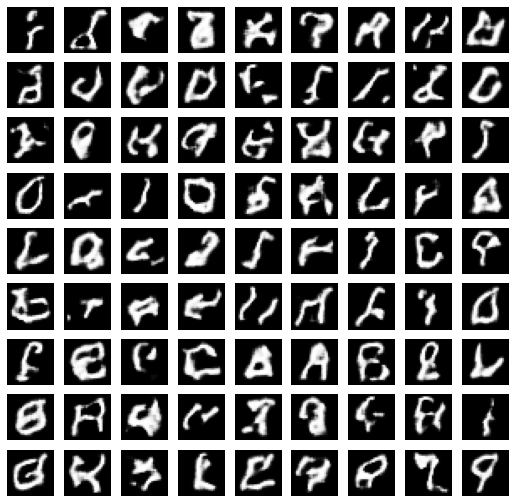

E:37,Loss G:0.6444,Loss D:0.5815,Acc G:%3.02, Acc D:%88.39
E:38,Loss G:0.6442,Loss D:0.5818,Acc G:%3.07, Acc D:%88.31


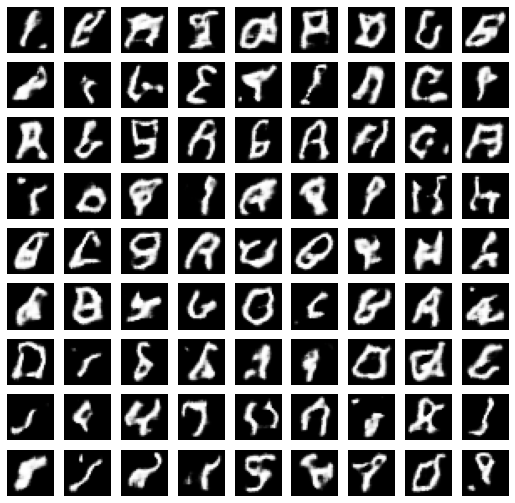

E:39,Loss G:0.6440,Loss D:0.5821,Acc G:%3.11, Acc D:%88.23
E:40,Loss G:0.6438,Loss D:0.5824,Acc G:%3.15, Acc D:%88.14


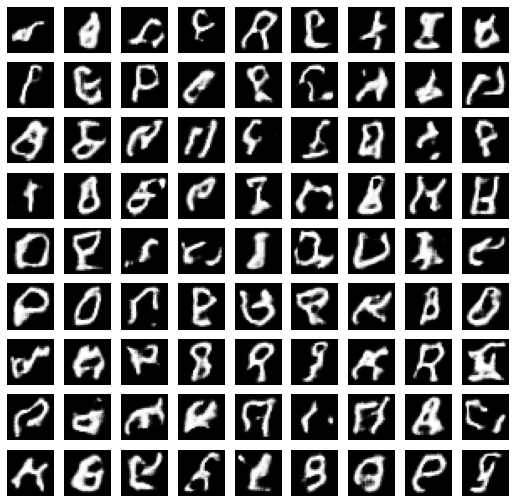

E:41,Loss G:0.6437,Loss D:0.5827,Acc G:%3.19, Acc D:%88.06
E:42,Loss G:0.6435,Loss D:0.5830,Acc G:%3.23, Acc D:%87.99


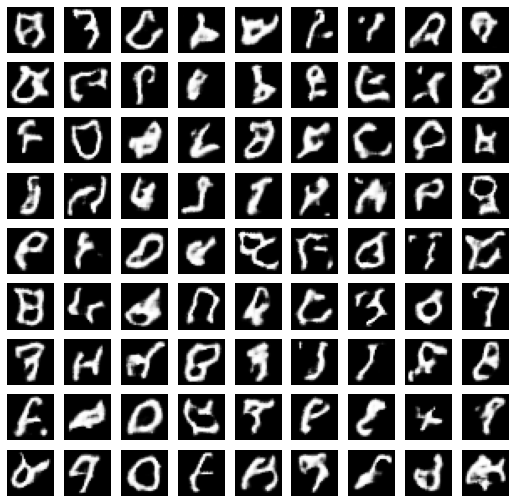

E:43,Loss G:0.6434,Loss D:0.5832,Acc G:%3.27, Acc D:%87.91
E:44,Loss G:0.6432,Loss D:0.5835,Acc G:%3.31, Acc D:%87.84


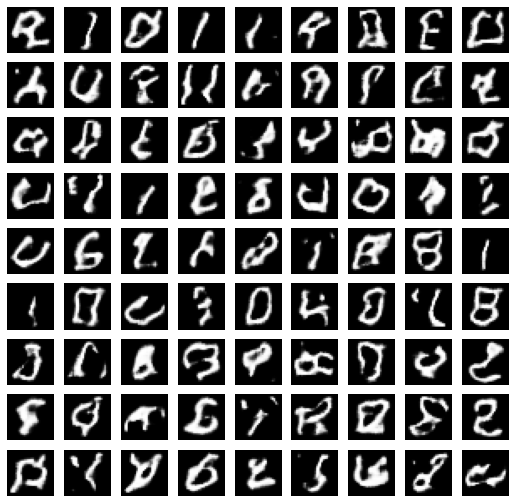

E:45,Loss G:0.6431,Loss D:0.5837,Acc G:%3.35, Acc D:%87.77
E:46,Loss G:0.6430,Loss D:0.5839,Acc G:%3.39, Acc D:%87.70


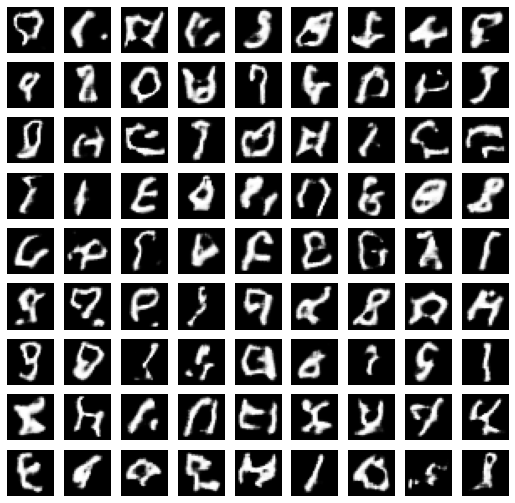

E:47,Loss G:0.6429,Loss D:0.5840,Acc G:%3.42, Acc D:%87.63
E:48,Loss G:0.6428,Loss D:0.5842,Acc G:%3.46, Acc D:%87.56


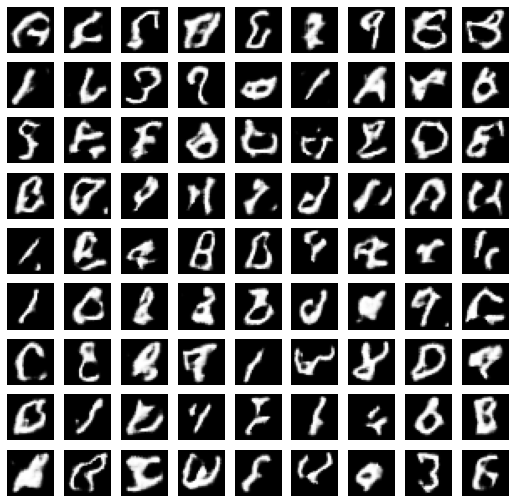

E:49,Loss G:0.6427,Loss D:0.5843,Acc G:%3.49, Acc D:%87.50


In [23]:
train(dset,50)

Generate images with trained model

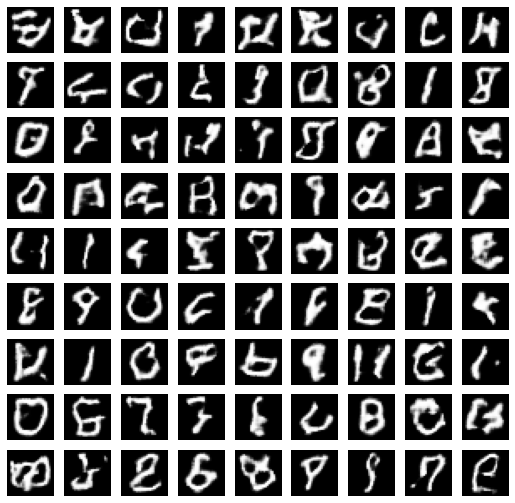

In [24]:
plotPics(generator)